In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import os
import pickle

In [2]:
import tcri
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell

## Configuration

In [26]:
#any without signed mi were  false
disease            = "bcc"
subset             = "CD8"
signed_mi          = True
init_ortho         = False
entropy_threshold  = 1.5
mutual_information = "/Users/ceglian/Data/tcri/{}_{}_{}_{}.p".format(disease,subset,signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
adata_h5ad         = "/Users/ceglian/Data/tcri/yost.h5ad"
embedding_size     = 100
alpha              = 0.00
beta               = 0.05
gain               = 10
vector_file        = "/Users/ceglian/Data/tcri/{}_{}_{}_{}_{}_{}_{}_{}.vec".format(disease,embedding_size, alpha, beta, gain, subset, signed_mi, init_ortho)
print(vector_file)
retrain            = True
annotated_h5ad     = "/Users/ceglian/Data/tcri/{}_{}_annoated.h5ad".format(disease,subset)
device             = "cpu"


cd8 = ['CD8_act',
        'CD8_eff',
        'CD8_ex',
        'CD8_ex_act',
        'CD8_mem']
cd4 = ['Naive',
        'Tfh',
        'Th17',
        'Tregs']

/Users/ceglian/Data/tcri/bcc_CD8_True_15.p
/Users/ceglian/Data/tcri/bcc_100_0.0_0.05_10_CD8_True_False.vec


In [27]:
import pandas as pd

## Read BCC data

In [34]:
adata = sc.read(adata_h5ad)
adata.X = csr_matrix(adata.X)
adata = adata[adata.obs["disease"] == "bcc"]
adata = spell.pp.remove_meaningless_genes(adata)

genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]


genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]
adata = adata[:,genes]

tcri.pp.register_clonotype_key(adata,"trb")
adata = adata[adata.obs[adata.uns["tcri_clone_key"]]!="None"]
if subset == "CD8":
    adata = adata[adata.obs["cluster"].isin(cd8)]
else:
    adata = adata[adata.obs["cluster"].isin(cd4)]
adata
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > 1.5]
adata
dataset = GeneVectorDataset(adata,load_expression=True,signed_mi=signed_mi,device=device)

100%|██████████| 15828/15828 [00:01<00:00, 8467.02it/s]


Running...
Loading Expression.
Indexing expression.


100%|██████████| 2254030/2254030 [00:01<00:00, 1912766.02it/s]

Finished.


In [35]:
# if os.path.exists(vector_file):
#     retrain = False
#     print("found previous model.")

if True:
    if os.path.exists(mutual_information):
        print("hit")
        dataset.mi_scores = pickle.load(open(mutual_information,"rb"))
    print(len(dataset.mi_scores),len(adata.var.index))
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        init_ortho=init_ortho,
                        device=device)
    if not os.path.exists(mutual_information):
        pickle.dump(dict(dataset.mi_scores),open(mutual_information,"wb"))

hit
419 350
*****************
Loading Dataset.
*****************



100%|██████████| 350/350 [00:00<00:00, 4988.65it/s]


MI Loaded.
Loading Batches for Training.


100%|██████████| 61075/61075 [00:00<00:00, 430454.11it/s]


Ready to train.


**** Epoch 0 	Loss: 2045943.125
**** Epoch 100 	Loss: 550179.53021
**** Epoch 200 	Loss: 143152.15339
**** Epoch 300 	Loss: 85394.66719
**** Epoch 400 	Loss: 67866.27891
**** Epoch 500 	Loss: 54441.19583
**** Epoch 600 	Loss: 43818.12174
**** Epoch 700 	Loss: 35557.10859
**** Epoch 800 	Loss: 29158.85931
**** Epoch 900 	Loss: 24187.56367
**** Epoch 1000 	Loss: 20295.25671
**** Epoch 1100 	Loss: 17216.96628
**** Epoch 1200 	Loss: 14755.64056
**** Epoch 1300 	Loss: 12766.83945
**** Epoch 1400 	Loss: 11144.31162
**** Epoch 1500 	Loss: 9810.31465
**** Epoch 1600 	Loss: 8706.61904
**** Epoch 1700 	Loss: 7789.35124
**** Epoch 1800 	Loss: 7024.21784
**** Epoch 1900 	Loss: 6382.87563
**** Epoch 2000 	Loss: 5842.25122
**** Epoch 2100 	Loss: 5384.15093
**** Epoch 2200 	Loss: 4992.84367
**** Epoch 2300 	Loss: 4655.85565
**** Epoch 2400 	Loss: 4363.03335
**** Epoch 2500 	Loss: 4107.88748
**** Epoch 2600 	Loss: 3883.48949
**** Epoch 2700 	Loss: 3684.51776
**** Epoch 2800 	Loss: 3506.57649
**** Epoc

100%|██████████| 350/350 [00:00<00:00, 299104.81it/s]


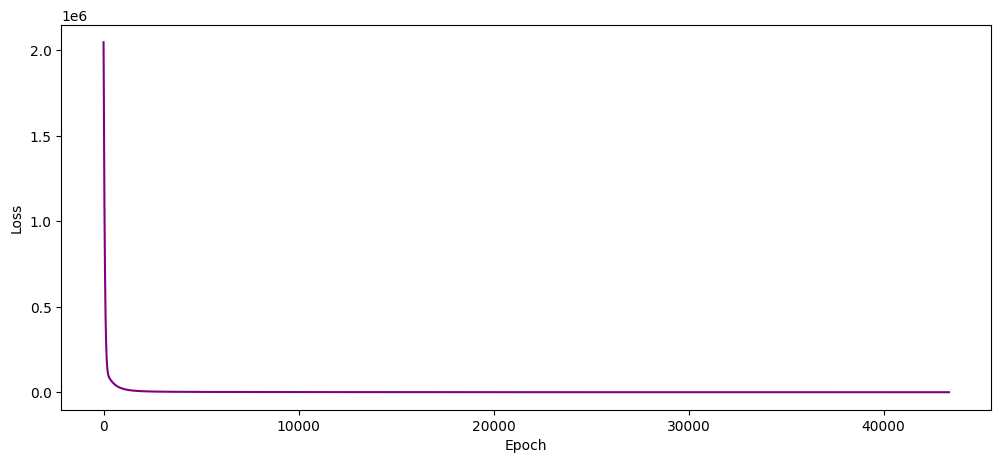

In [36]:
if retrain:
    cmps.train(100000,threshold=1e-3,alpha=alpha, beta=beta, update_interval=100)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [37]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
if False:
    cembed.batch_correct(column="patient",reference="su012")
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 2254030/2254030 [00:03<00:00, 645891.20it/s]


Generating Cell Vectors.


100%|██████████| 9563/9563 [00:00<00:00, 11207.71it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 9563 × 350
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_genevector'
    obsp: 'distances', 'connectivities'

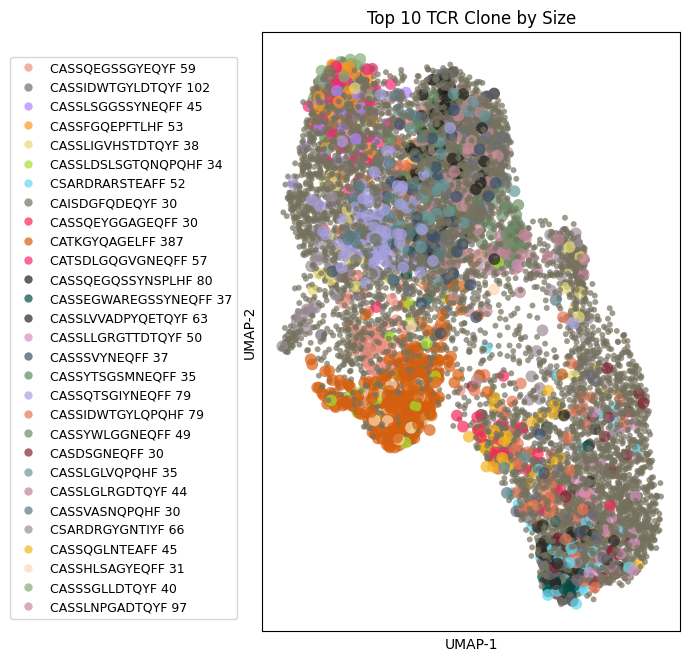

In [38]:
tcri.pl.clone_umap(adata,top_n=30,size=5,figsize=(7,7))

In [39]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

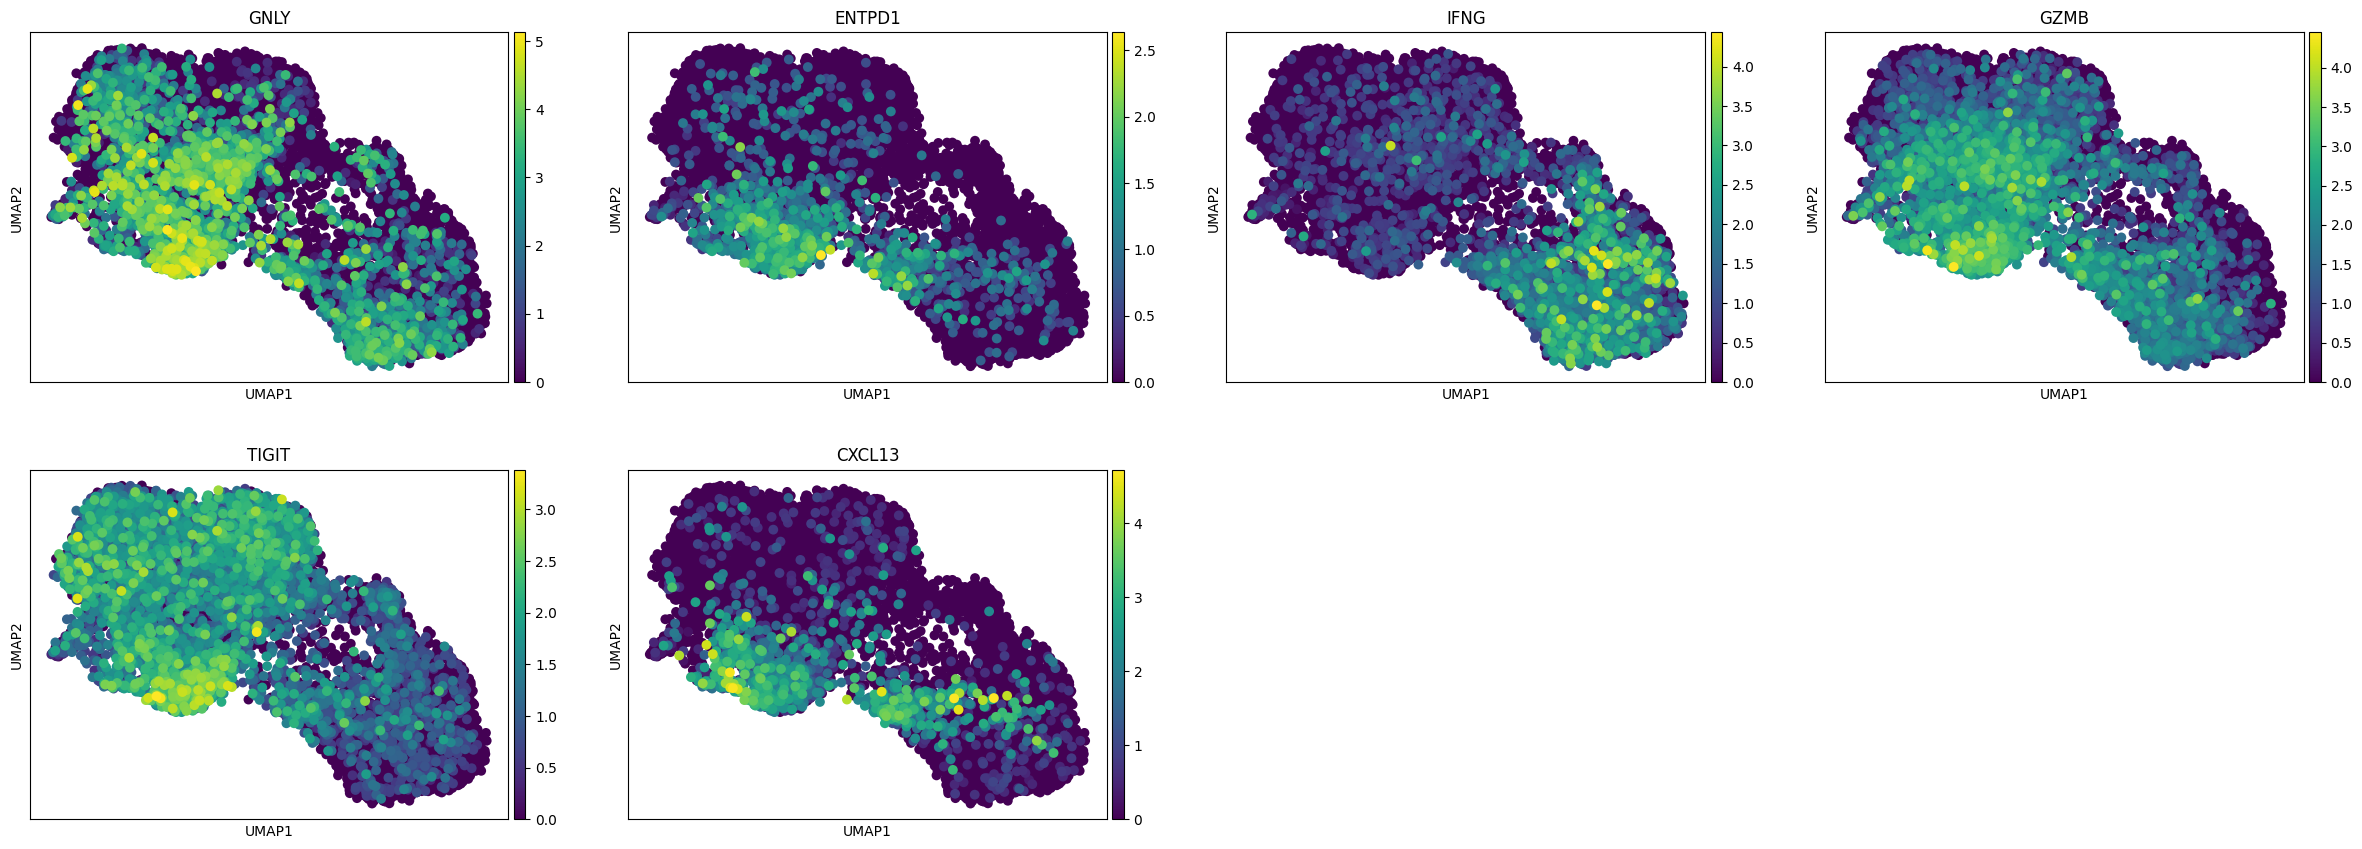

In [221]:
sc.pl.umap(adata,color=["GNLY","ENTPD1","IFNG","GZMB","TIGIT","CXCL13"],s=200)

In [232]:
markers = dict()
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential", temperature=0.01,return_distances=True)

Using Normalized Exponential (Temp: 0.01)
Computing similarities for Memory
Markers: GZMK


100%|██████████| 9563/9563 [00:00<00:00, 66603.56it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 9563/9563 [00:00<00:00, 77153.41it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 9563/9563 [00:00<00:00, 75177.78it/s]


<Axes: xlabel='genevector', ylabel='count'>

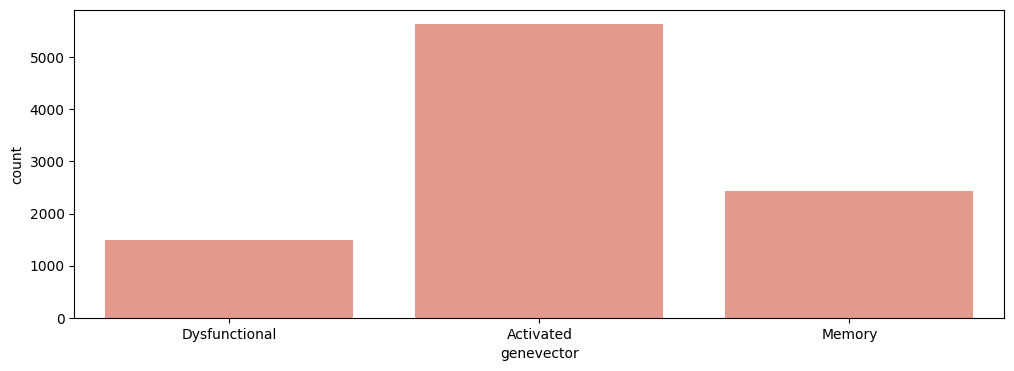

In [230]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="genevector",ax=ax)


<Axes: xlabel='cluster', ylabel='count'>

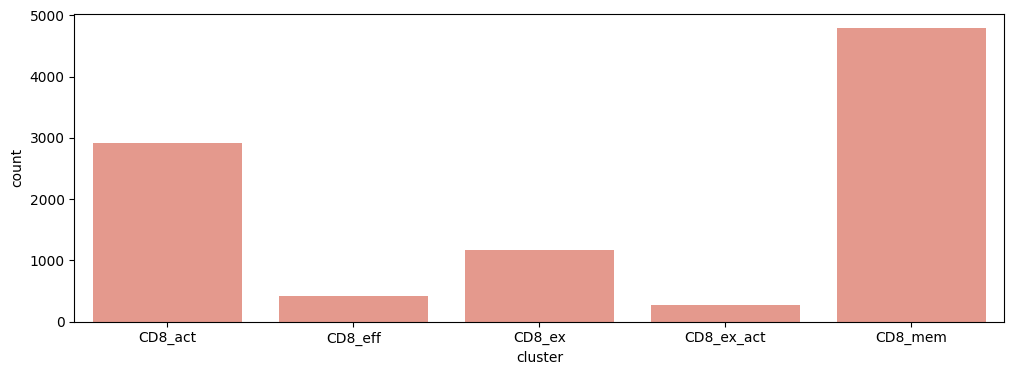

In [226]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="cluster",ax=ax)

<Axes: xlabel='genevector', ylabel='cluster'>

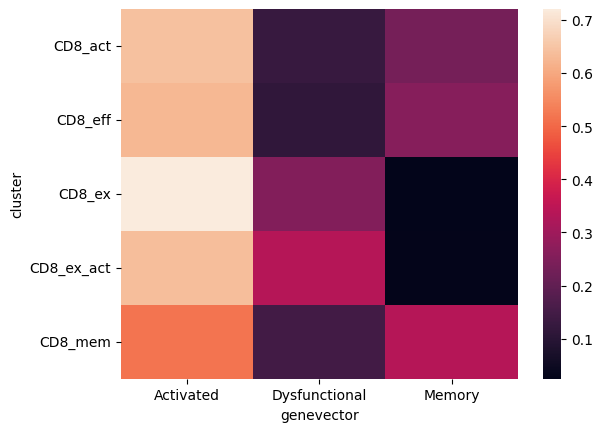

In [227]:

cembed.compare_classification(adata,"cluster","genevector")

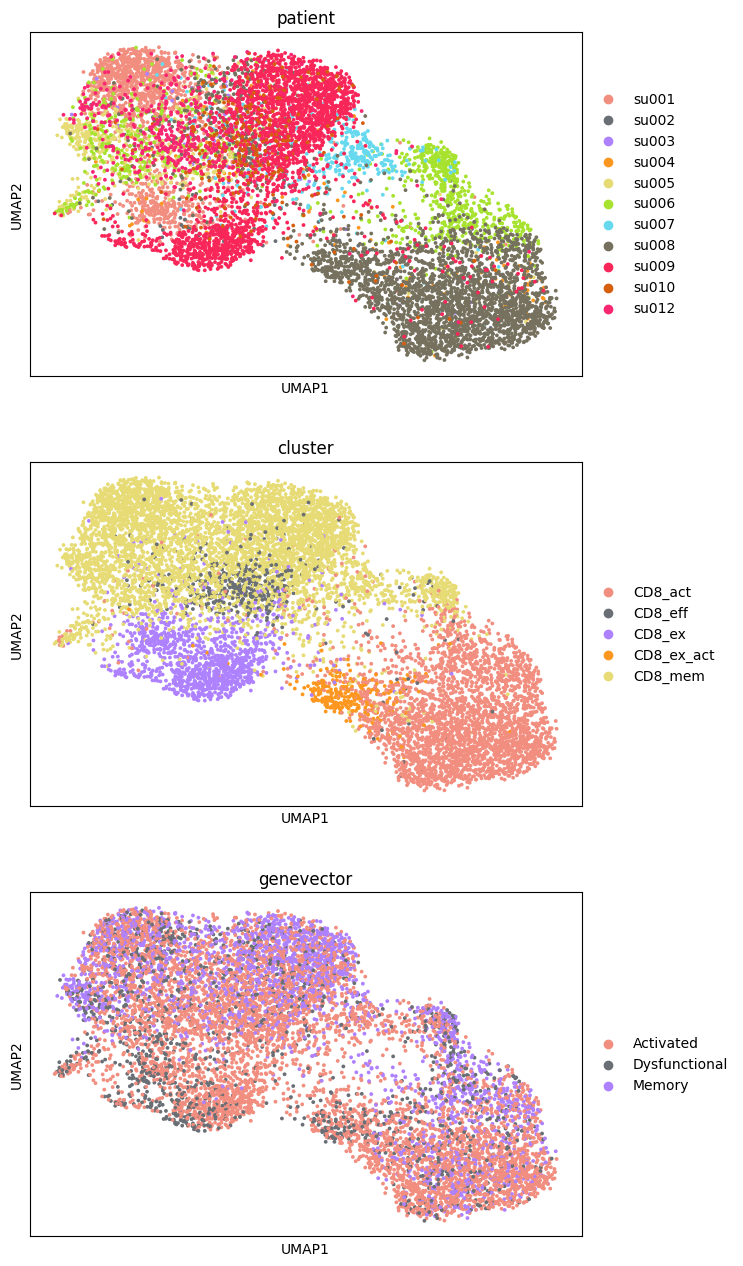

In [228]:
sc.pl.umap(adata,color=["patient","cluster","genevector"],s=30,wspace=0.2, ncols=1)

100%|██████████| 9563/9563 [00:00<00:00, 74679.49it/s]


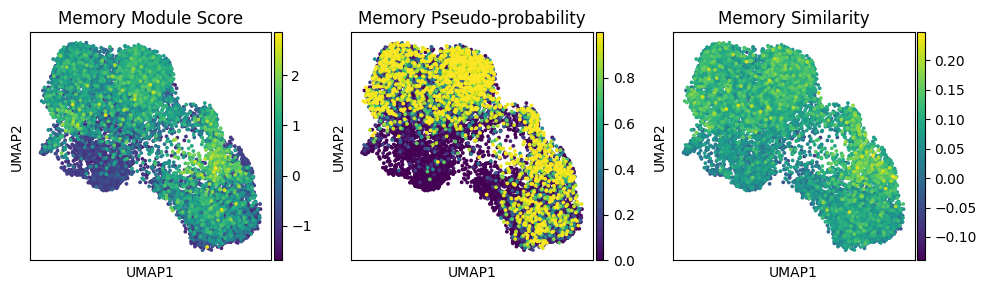

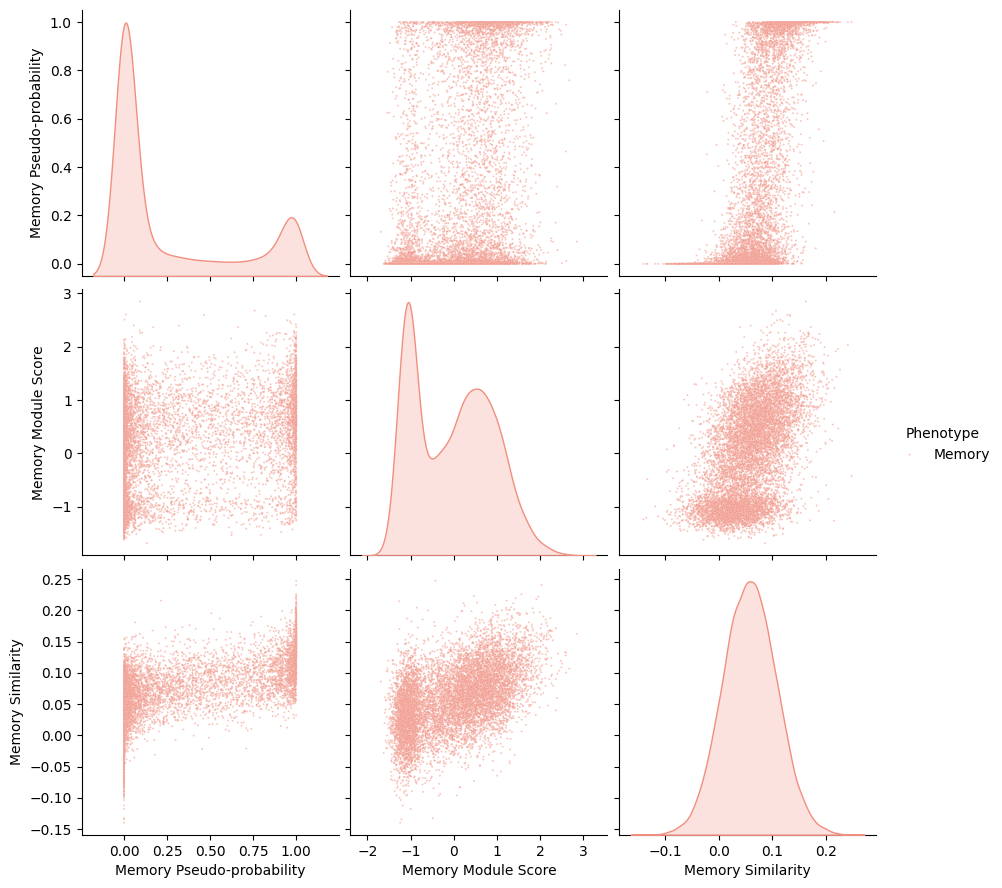

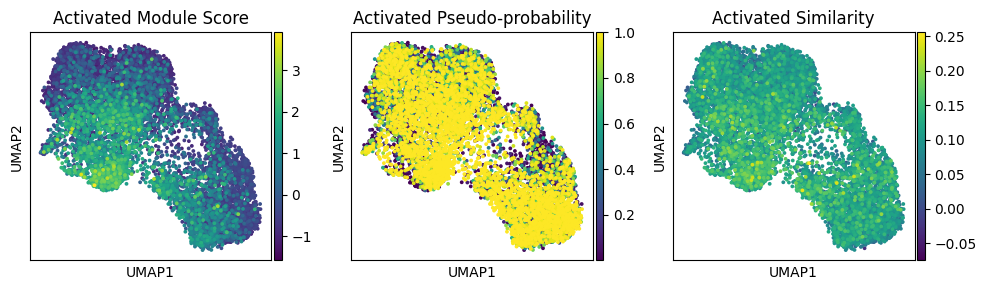

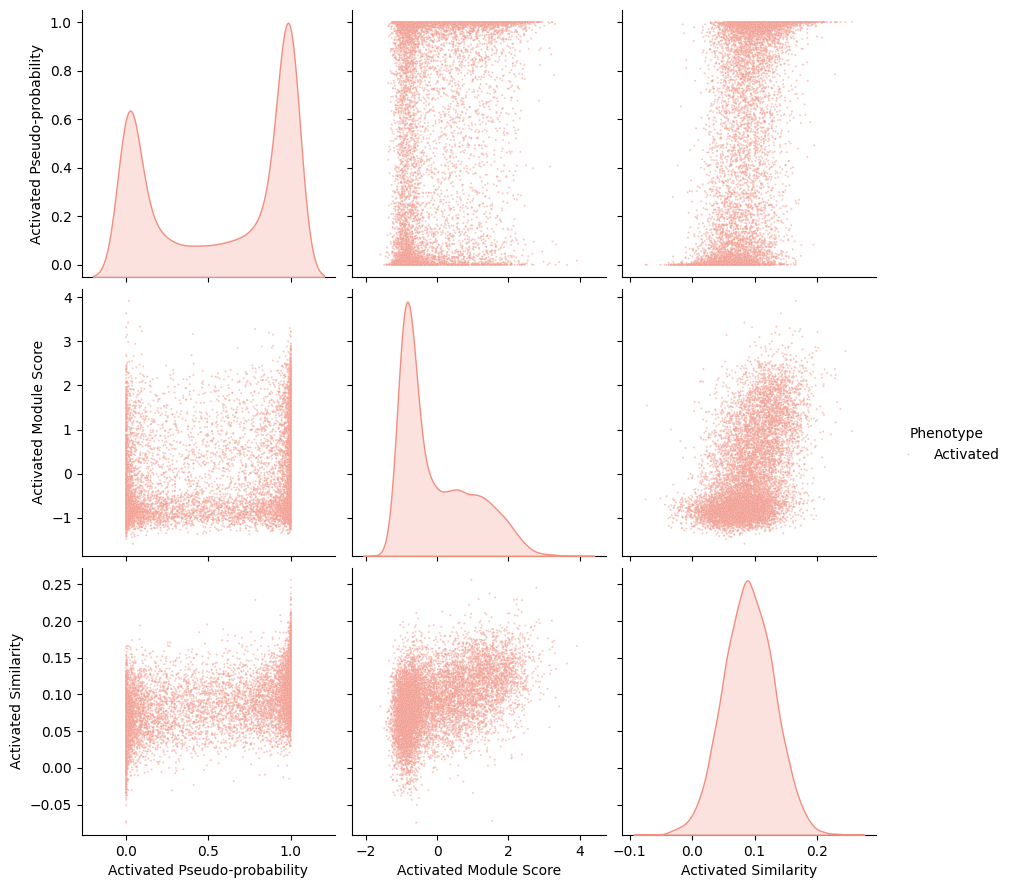

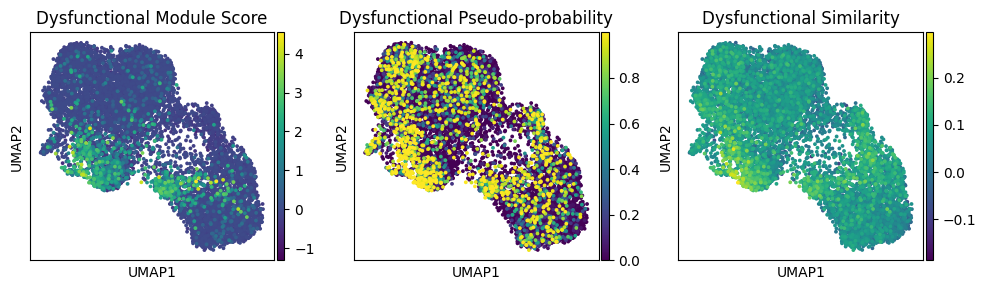

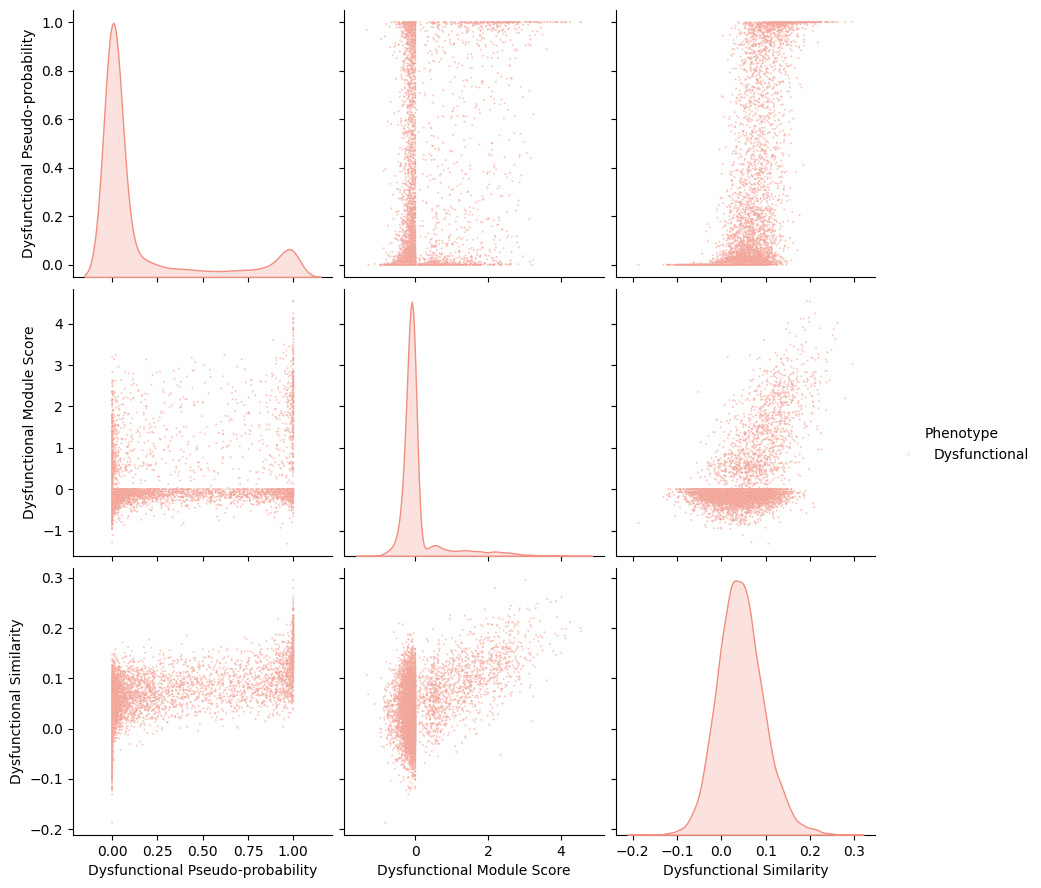

In [233]:
for phenotype, genes  in markers.items():
    cembed.phenotype_qc(adata,phenotype,genes)

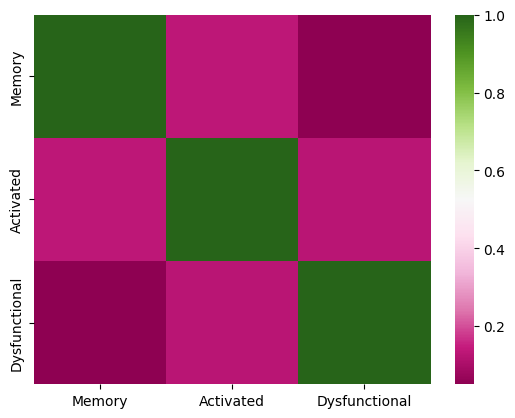

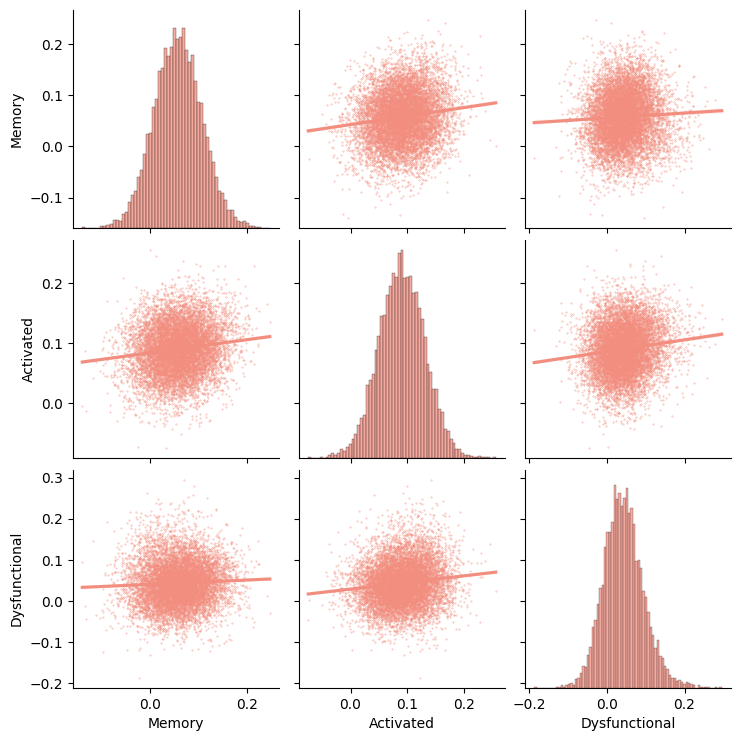

In [234]:
ddf = pd.DataFrame(data = np.array(dist["distances"]),columns=dist['order'])
mat = pd.DataFrame(np.corrcoef(ddf.to_numpy().T),index=dist["order"],columns=dist["order"])
sns.heatmap(mat,cmap="PiYG")
sns.pairplot(data=ddf,kind="reg",plot_kws={"scatter_kws":{"s":0.1}})

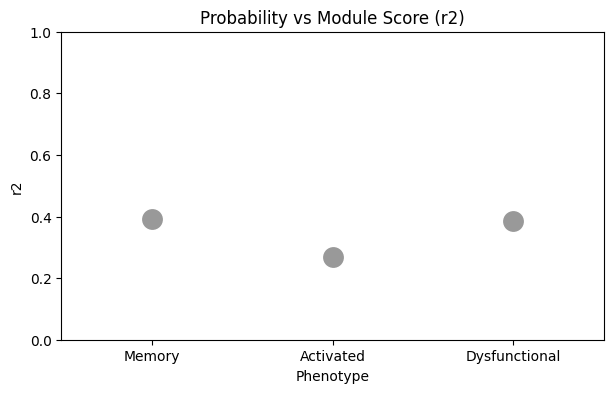

In [235]:
cembed.module_score_r2(adata,markers)

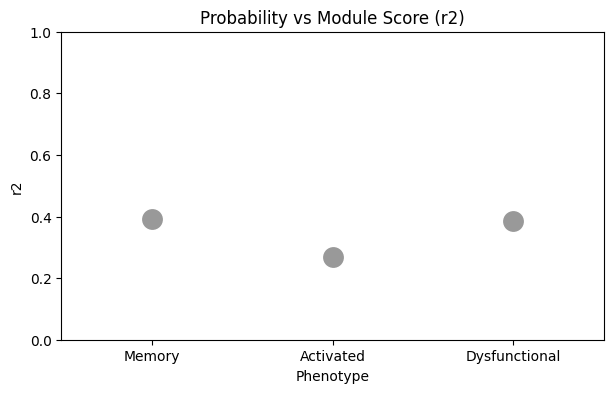

In [236]:
cembed.module_score_r2(adata,markers)

In [237]:
tcri.pp.register_phenotype_key(adata,"genevector")
tcri.pp.register_clonotype_key(adata,"trb")

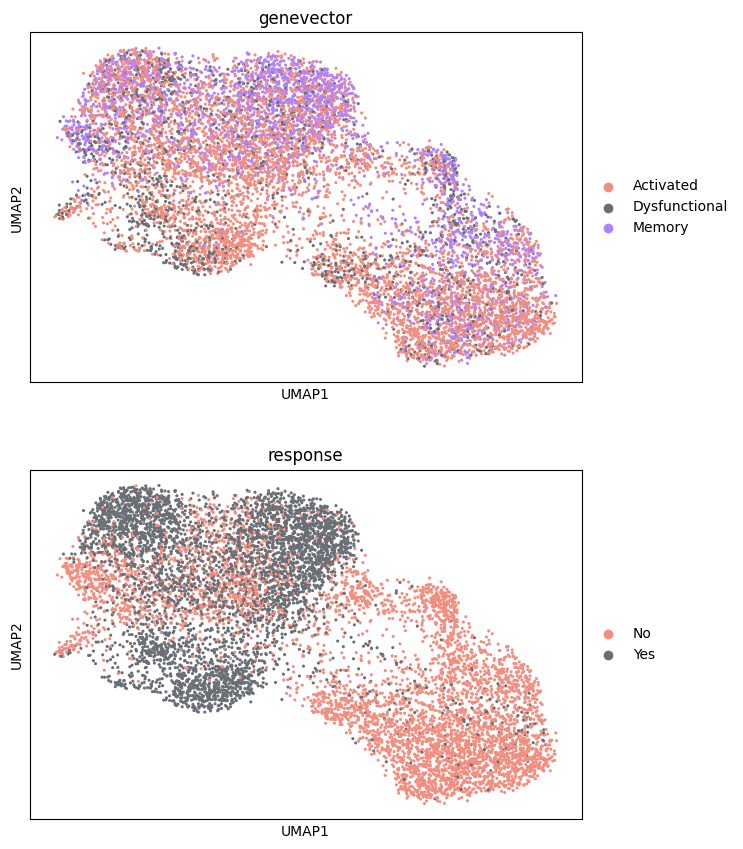

In [238]:
sc.pl.umap(adata,color=["genevector","response"],palette=tcri.pl.tcri_colors,s=20, wspace=0.2,ncols=1, save="bcc.pdf")
!cp figures/umapbcc.pdf ~

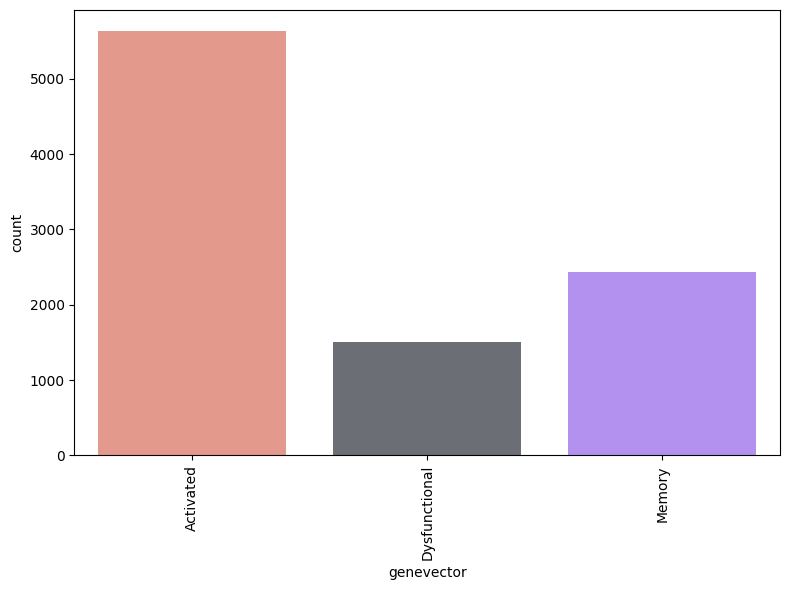

In [239]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.countplot(data=adata.obs,x="genevector",palette=tcri.pl.tcri_colors,ax=ax)
plt.xticks(rotation=90)
fig.tight_layout()

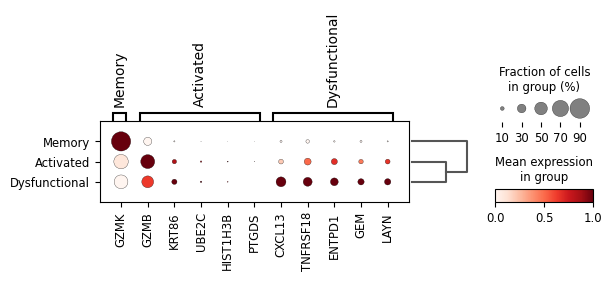

In [240]:
sc.tl.rank_genes_groups(adata,"genevector")
sc.tl.dendrogram(adata,"genevector")
sc.pl.rank_genes_groups_dotplot(adata,min_logfoldchange=1.,standard_scale='var',n_genes=5,save="tri_markers.pdf")
!cp figures/dotplot_tri_markers.pdf ~

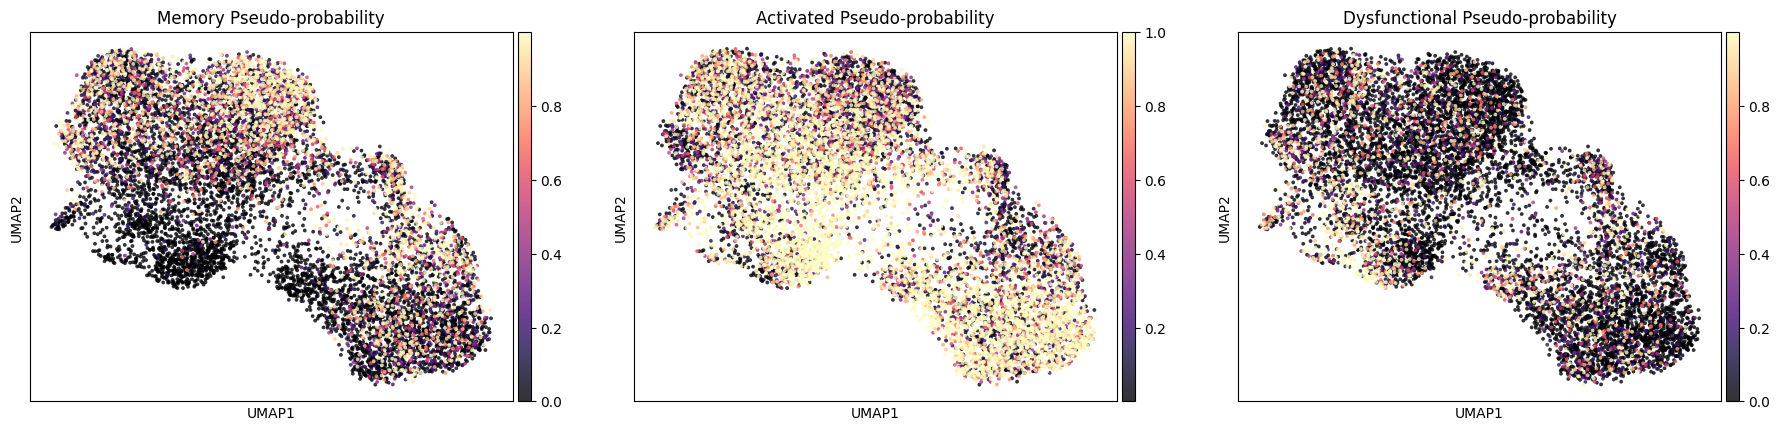

In [241]:

cembed.plot_probabilities(adata)
!cp figures/umapprobs.pdf ~

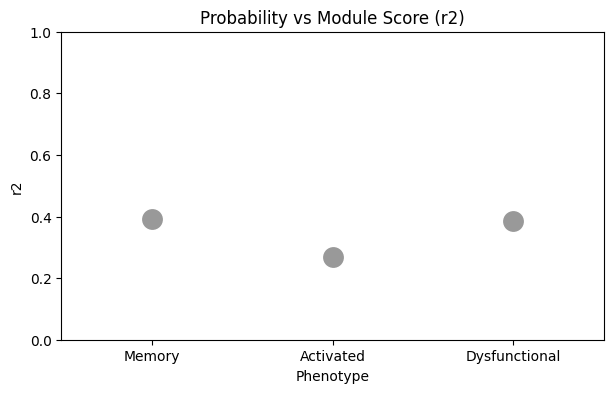

In [242]:
cembed.module_score_r2(adata,markers)

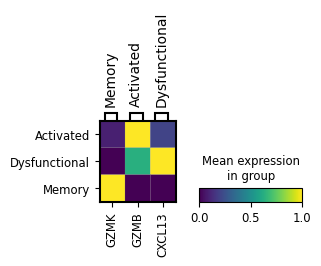

In [243]:
sc.pl.matrixplot(adata,markers,groupby="genevector",standard_scale="var")

In [244]:
from tcri.utils import *
def phenotypic_flux(adata, splitby, order, clones=None, normalize=True):
    phenotypes = Phenotypes(adata.obs[adata.uns["tcri_phenotype_key"]].unique())
    repertoires = dict()
    times = list(range(len(order)))
    for s in order:
        repertoires[s] = CellRepertoire(clones_and_phenos = {}, 
                                        phenotypes = phenotypes, 
                                        use_genes = False, 
                                        use_chain = False,
                                        seq_type = 'ntseq',
                                        chains_to_use = ['TRB'],
                                        name = s)
    for condition, seq, phenotype in zip(adata.obs[splitby],
                                         adata.obs[adata.uns["tcri_clone_key"]],
                                         adata.obs[adata.uns["tcri_phenotype_key"]]):
        if str(seq) != "nan" and condition in repertoires:
            repertoires[condition].cell_list.append(Tcell(phenotypes = phenotypes, 
                                                          phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(aaseq = seq), 
                                                          use_genes = False))
    for condition, rep in repertoires.items():
        rep._set_consistency()
    fig, ax = plot_pheno_sankey(phenotypes = phenotypes, 
                                cell_repertoires = [repertoires[condition] for condition in order], 
                                clones = clones,
                                times = times,
                                xlim = [min(times), max(times)],
                                time_rescale = 1,
                                normalize=True,
                                xlabel = splitby,
                                return_axes = True, 
                                show_legend = True)
    ax.set_xticks(times)
    ax.set_xticklabels(order)
    fig.savefig("test.png")

In [245]:
tcri.pp.clone_size(adata)

In [246]:
s = []
r = []
e = []
for tcr, ent in tcri.tl.phenotypic_entropies(adata,normalized=False).items():
    response = adata[adata.obs['trb'] == tcr].obs['response'].tolist()
    response = list(set(response))[0]
    size = adata[adata.obs['trb'] == tcr].obs['clone_size'].tolist()
    size = list(set(size))[0]
    e.append(ent)
    s.append(size)
    r.append(response)
df = pd.DataFrame.from_dict({"Entropy":e, "Response":r, "Size": s})
df

Entropy Response  Size
0     0.228339      Yes     1
1     0.258506       No     1
2     0.830373       No     2
3     0.985135       No     2
4     0.000236       No     1
...        ...      ...   ...
3694  0.698869      Yes     1
3695  0.066374       No     1
3696  0.013005       No     1
3697  0.625340       No     1
3698  0.258052      Yes     2

[3699 rows x 3 columns]

<Axes: xlabel='Entropy', ylabel='Size'>

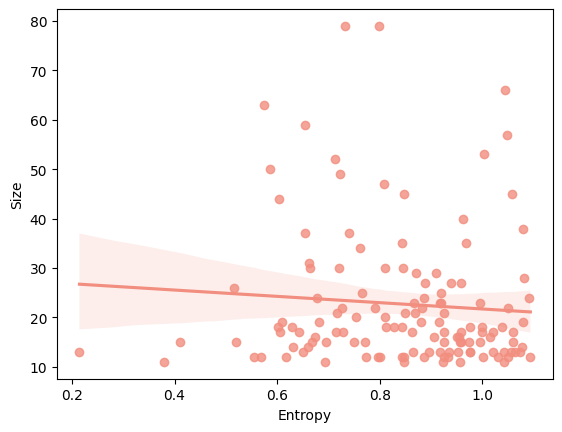

In [247]:
dfx=df[df["Size"]<80]
dfx=dfx[dfx["Size"] > 10]
sns.regplot(data=dfx,x='Entropy',y="Size")

2


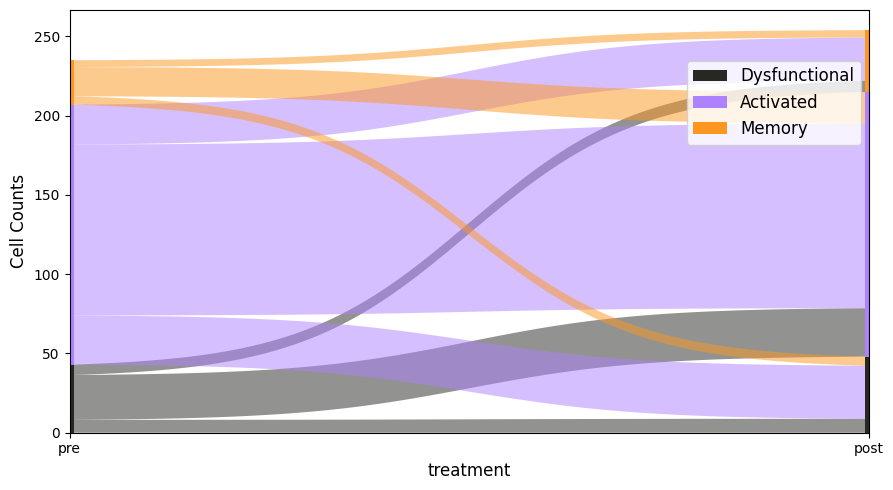

In [248]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] >100]
print(len(set(responder.obs["trb"])))
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], normalize=False,nt=False)
plt.savefig("/Users/ceglian/resp_bcc.pdf")

3


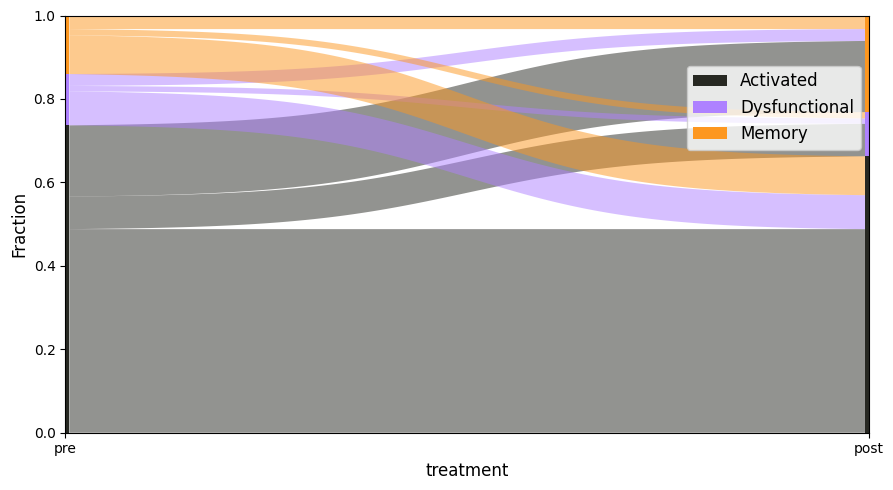

In [250]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 60]
print(len(set(responder.obs["trb"])))
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],normalize=True,nt=False)
plt.savefig("/Users/ceglian/nresp_bcc.pdf")

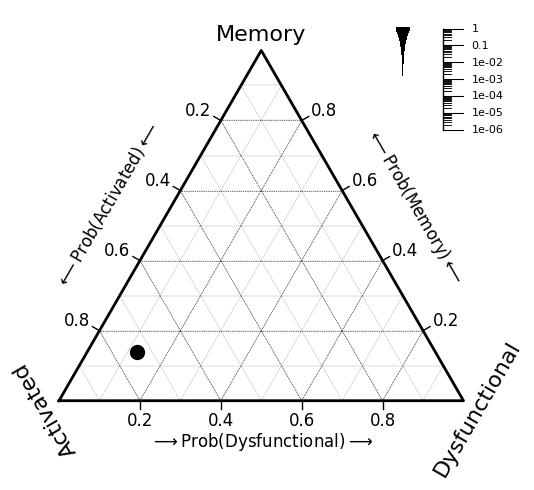

In [251]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 60]
tcri.pl.ternary_plot(responder,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="treatment",condition="post")
plt.savefig("/Users/ceglian/nresp_bcc_tern.pdf")

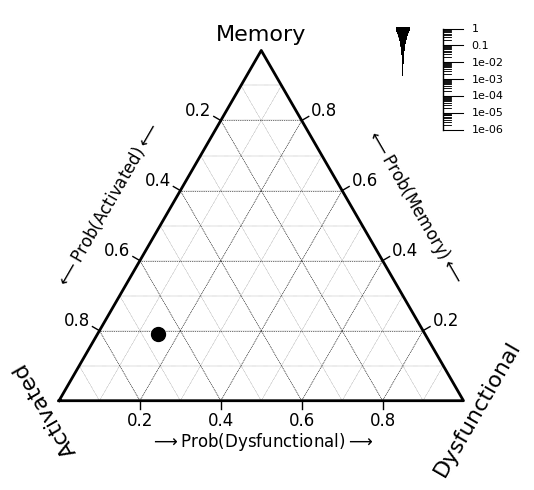

In [197]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 60]
tcri.pp.joint_distribution(responder)
tcri.pl.ternary_plot(responder,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="treatment",condition="post")
plt.savefig("/Users/ceglian/resp_bcc_tern.pdf")

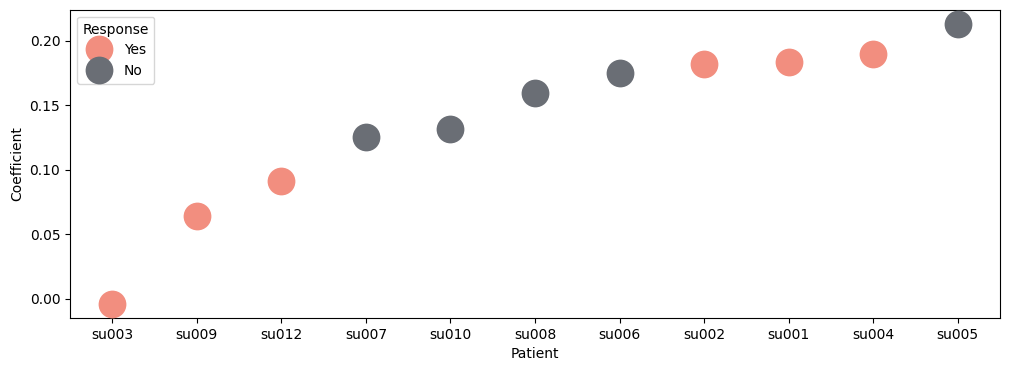

In [201]:
def phenotypic_entropies(adata, method="probabilistic", normalized=True):
    tcri.pp.joint_distribution(adata, method=method)
    tcr_sequences = adata.obs[adata.uns["tcri_clone_key"]].tolist()
    unique_tcrs = np.unique(tcr_sequences)
    jd = adata.uns["joint_distribution"].to_numpy() 
    jd = jd / np.sum(jd)
    clonotype_entropies = np.zeros(jd.shape[1])
    max_entropy = np.log(jd.shape[0])
    for i, clonotype_distribution in enumerate(jd.T):
        normalized_distribution = clonotype_distribution / np.sum(clonotype_distribution)
        epsilon = np.finfo(float).eps
        if normalized:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon)) / max_entropy
        else:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon))
    tcr_to_entropy_dict = dict(zip(unique_tcrs, clonotype_entropies))
    return tcr_to_entropy_dict


groupby = "patient"
ps = []
rs = []
r2 = []
for r in set(adata.obs["response"]):
    rdata = adata[adata.obs["response"] == r]
    for p in set(rdata.obs[groupby]):
        clone = []
        size = []
        ent = []
        pdata = rdata[rdata.obs[groupby] == p]
        ents = phenotypic_entropies(pdata)
        tcri.pp.clone_size(pdata)
        sizes = dict(zip(pdata.obs[pdata.uns["tcri_clone_key"]],pdata.obs["clone_size"]))
        for tcr,entropy in ents.items():
            ent.append(entropy)
            size.append(sizes[tcr])
            clone.append(tcr)
        df = pd.DataFrame.from_dict({"Entropy":ent,"Size":size,"TCR":clone})
        c = df["Entropy"].corr(df["Size"])
        ps.append(p)
        rs.append(r)
        r2.append(c)
df = pd.DataFrame.from_dict({"Patient":ps,"Response":rs,"Coefficient":r2})
df
fig, ax = plt.subplots(1,1,figsize=(12,4))
df = df.sort_values("Coefficient")
sns.stripplot(data=df, x="Patient",y="Coefficient",s=20, hue="Response",ax=ax)
fig.savefig("/Users/ceglian/phenotypic_entropy.pdf")

<Axes: title={'center': 'Clonotypic Entropy'}, xlabel='Phenotype', ylabel='Clonotypic Entropy'>

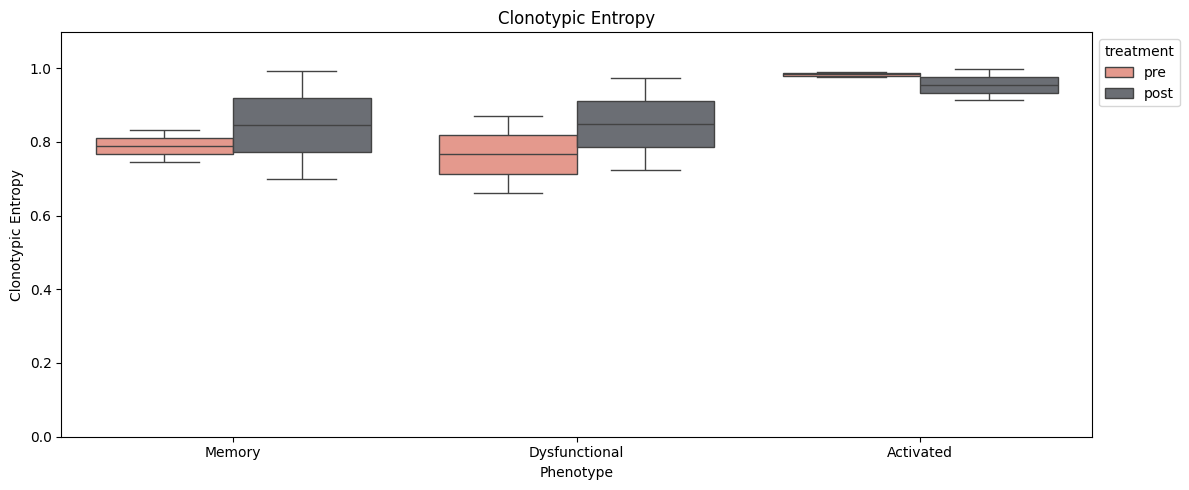

In [140]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')

View of AnnData object with n_obs × n_vars = 1598 × 350
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response', 'Size', 'TCR Sequence', 'genevector', 'Naive Similarity', 'Naive Module Score', 'Memory Similarity', 'Memory Module Score', 'Activated Similarity', 'Activated Module Score', 'Dysfunctional Similarity', 'Dysfunctional Module Score', 'clone_size', 'Memory Pseudo-probability', 'Activated Pseudo-probability', 'Dysfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'log1p', 'probability_columns', 'patient_colors', 'genevector_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'rank_genes_groups', 'dendrogram_genevector', 'response_colors'
    obsm: 'X_umap', 'X_genevector', 'X_pca'
    obsp: 'distances', 'connectivities'


<Axes: title={'center': 'Clonotypic Entropy'}, xlabel='Phenotype', ylabel='Clonotypic Entropy'>

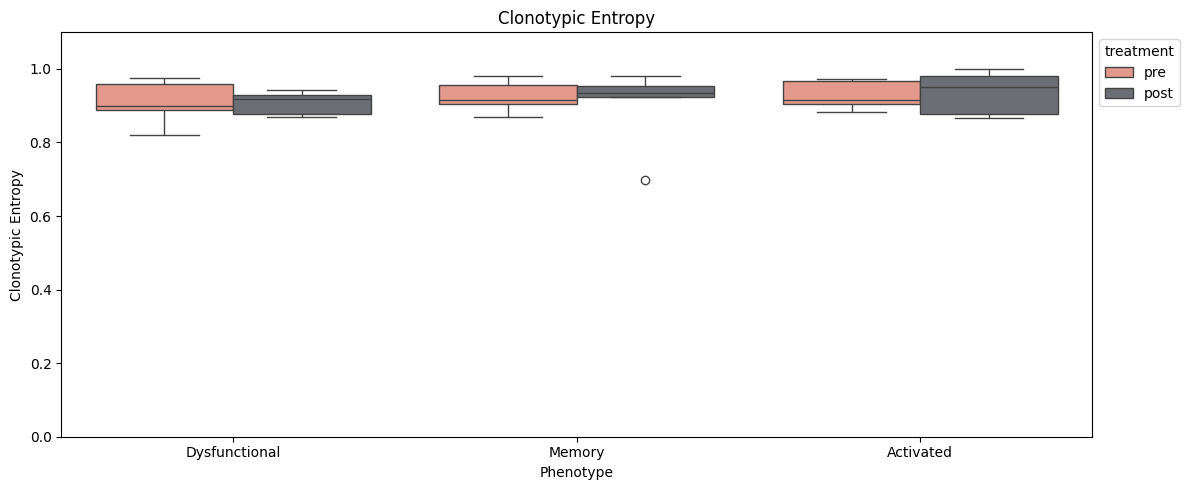

In [143]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 10]
print(responder)
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

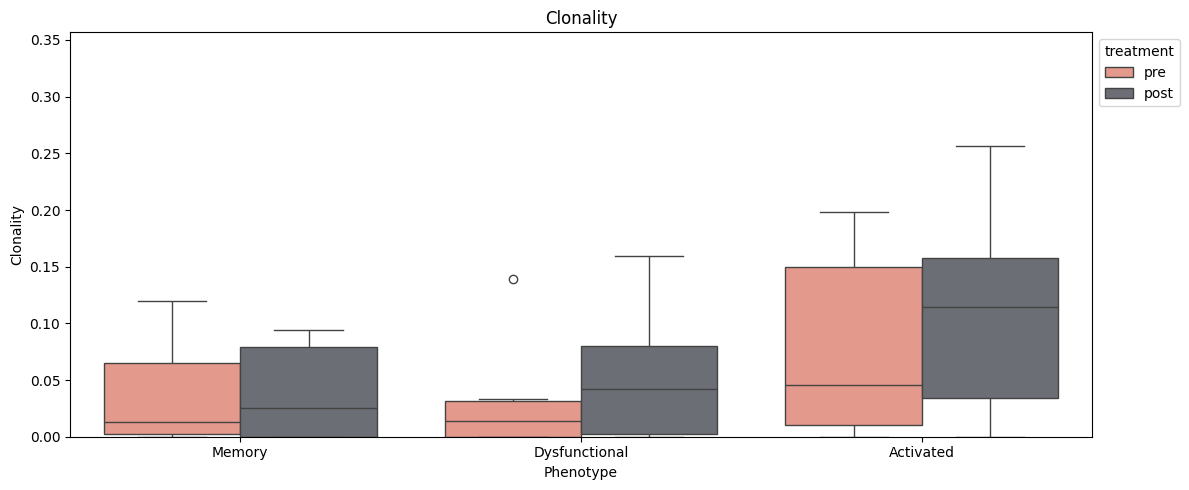

In [136]:
responder = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

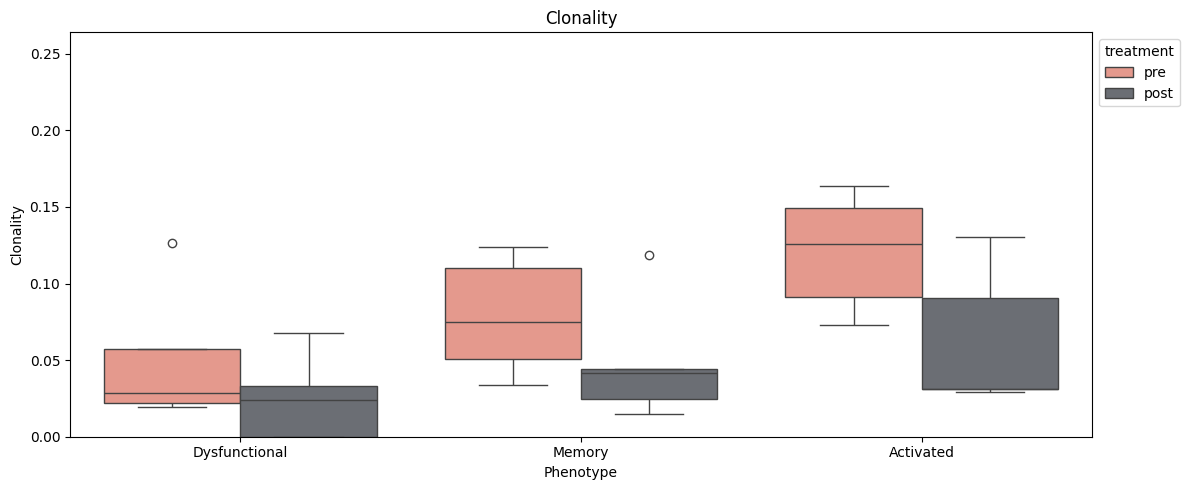

In [145]:
responder = adata[adata.obs["response"] == "No"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

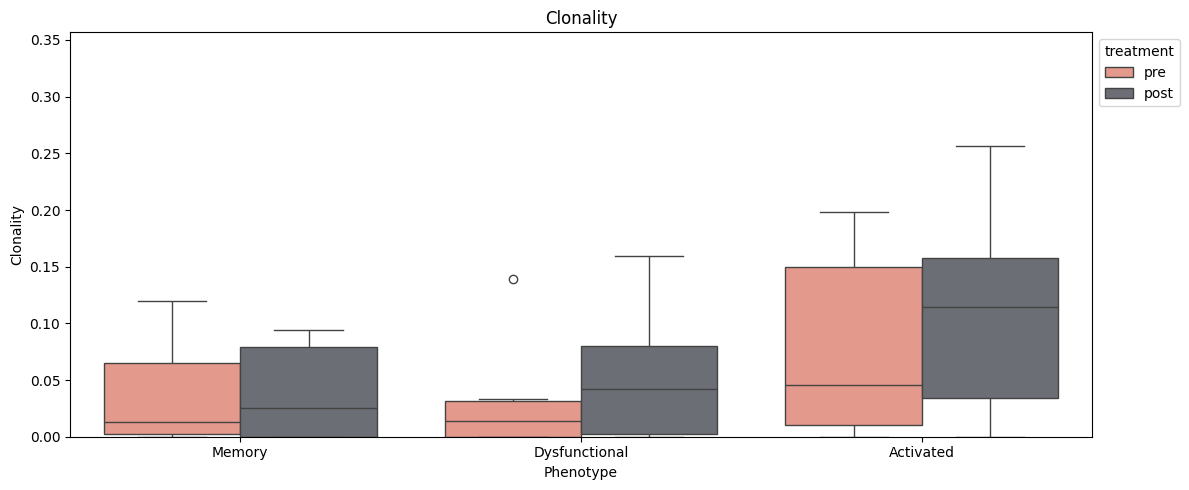

In [146]:
responder = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")